In [1]:
import configparser
import numpy as np
from datetime import datetime
import pickle
import psycopg2

import pandas as pd
import geopandas as gpd
import psycopg2
from osgeo import gdal, gdal_array
from skimage.draw import polygon2mask
import matplotlib.pyplot as plt

from tathu.io import pgis
from tathu import visualizer
from tathu.utils import (
    extractPeriods,
    file2timestamp,
    getGeoT,
    geo2grid,
)
from tathu.geometry.transform import shapely2ogr
from tathu.geometry.utils import extractCoordinates
from tathu.constants import LAT_LON_WGS84
from tathu.io.pgis import bytea2nparray, _adapt_array

from read_sipam_cappis_cptec import read_simple_cappi

# Tell pgis how to deal with numpy arrays
psycopg2.extensions.register_adapter(np.ndarray, _adapt_array)

from my_secrets import postgis_pwd

In [2]:
# File paths
gld_path = "/home/camilacl/git/amazon-storms-aerosols/data/lightning/GLD_mod/"
radar_path = "/data2/GOAMAZON/radar/sipam_manaus/cptec_cappi/"
init_path = "/home/camilacl/git/amazon-storms-aerosols/data/general/"

# Load family
db = pgis.Loader(
    "localhost", "goamazon_geo", "postgres", "postgres", "systems_filtered"
)
# Get systems
names = db.loadNames()
# print(len(names))
# Get dates
dates = db.loadDates()
print(len(dates))

19199


### Fill classification

In [3]:
# f = db.load(names[0], ['gld'])
# np.sum([x for x in [None, None] if x is not None])

In [4]:
# for name in names[:5]:
#     fam = db.load(
#         name, ["count", "max", "event"]
#     )
#     # Getting data
#     timestamps = fam.getTimestamps()
#     events = fam.getAttribute("event")
#     max_area = np.max(fam.getAttribute("count"))
#     max_z = np.max(fam.getAttribute("max"))
#     duration = timestamps[-1] - timestamps[0]
#     init_ts = timestamps[0]
#     print(init_ts)
    
#     if max_area <= 1000:
#         clf_area = 'small'
#     else:
#         clf_area = 'large'
    
#     if max_z >= 55:
#         clf_z = 'intense'
#     else:
#         clf_z = 'no_intense'
    
#     if ('SPLIT' in events) | ('MERGE' in events):
#         clf_life = 'with_splitmerge'
#     else:
#         clf_life = 'no_splitmerge'
    
#     if duration.total_seconds() <= 3600:
#         clf_duration = 'short_span'
#     elif (duration.total_seconds() > 3600) & (duration.total_seconds() <= 3600*3):
#         clf_duration = "medium_span"
#     else:
#         clf_duration = 'large_span'
        
#     if init_ts.month in [1,2,3]:
#         clf_season = 'wet'
#     elif init_ts.month in [8, 9, 10]:
#         clf_season = 'dry'
#     elif init_ts.month in [11, 12]:
#         clf_season = 'dry-to-wet'
#     else:
#         clf_season = ''
    
#     if init_ts.hour in [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]:
#         clf_timeofday = 'diurnal'
#     else:
#         clf_timeofday = 'nocturnal'
    
#     print(duration)
#     print(events)
#     print(clf_life)
#     print(clf_duration)
#     print(clf_season)
#     print(clf_timeofday)

## Systems 25 km

### Correlations

In [3]:
# -- CS name, duration
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
names = [q[0] for q in db.query(query)]
durations = [q[1] for q in db.query(query)]

# -- Single params
query = (
    "SELECT DISTINCT ON (name) date_init25, totaerosol25_1_cm3, totccn25_1_cm3,"
    " cape25_j_kg, cin25_j_kg, blrh25_pc, lvws25_m_s, ufaerosol25_1_cm3, wcd25_km FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
date_init = [q[0] for q in db.query(query)]
totaerosol = [q[1] for q in db.query(query)]
totccn = [q[2] for q in db.query(query)]
cape = [q[3] for q in db.query(query)]
cin = [q[4] for q in db.query(query)]
blrh = [q[5] for q in db.query(query)]
lvws = [q[6] for q in db.query(query)]
ufaerosol = [q[7] for q in db.query(query)]
wcd = [q[8] for q in db.query(query)]

# -- Max, sum params
query = (
    "SELECT MAX(count), MAX(max), MAX(echotop_0), MAX(echotop_20),"
    " MAX(echotop_40), MAX(maxvil_kgm2), MAX(maxvii_kgm2), MAX(maxviwl_kgm2) FROM systems_filtered"
    " GROUP BY name ORDER BY name ASC"
)
maxarea = [q[0] for q in db.query(query)]
maxz = [q[1] for q in db.query(query)]
maxecho0 = [q[2] for q in db.query(query)]
maxecho20 = [q[3] for q in db.query(query)]
maxecho40 = [q[4] for q in db.query(query)]
maxvil = [q[5] for q in db.query(query)]
maxvii = [q[6] for q in db.query(query)]
maxviwl = [q[7] for q in db.query(query)]

query = "SELECT SUM(gld) FROM systems_filtered GROUP BY name ORDER BY name ASC"
gld = [q[0] for q in db.query(query)]

# -- Classifications
query = (
    "SELECT DISTINCT ON (name) clf_area, clf_z, clf_life, clf_duration,"
    " clf_season, clf_timeofday, clf_lightning FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
clf_area = [q[0] for q in db.query(query)]
clf_z = [q[1] for q in db.query(query)]
clf_life = [q[2] for q in db.query(query)]
clf_duration = [q[3] for q in db.query(query)]
clf_season = [q[4] for q in db.query(query)]
clf_timeofday = [q[5] for q in db.query(query)]
clf_lightning = [q[6] for q in db.query(query)]

In [4]:
systems = pd.DataFrame(
    {
        'name': names,
        'duration': [float(d) for d in durations],
        'date_init': date_init,
        'max_area': maxarea,
        'max_z': maxz,
        'max_echotop0': maxecho0,
        'max_echotop20': maxecho20,
        'max_echotop40': maxecho40,
        'gld': gld,
        'totaerosol': totaerosol,
        'ufaerosol': ufaerosol,
        'cape': cape,
        'cin': cin,
        'blrh': blrh,
        'lvws': lvws,
        'wcd': wcd,
        'max_vil': maxvil,
        'max_vii': maxvii,
        'max_viwl': maxviwl,
        'clf_area': clf_area,
        'clf_z': clf_z,
        'clf_life': clf_life,
        'clf_duration': clf_duration,
        'clf_season': clf_season,
        'clf_timeofday': clf_timeofday,
        'clf_lightning': clf_lightning,
    }
).set_index('name').replace(r'^\s*$', np.nan, regex=True)
systems['hour_init'] = systems.date_init.dt.hour
systems['month_init'] = systems.date_init.dt.month

In [5]:
systems.dropna().describe()

,duration,max_area,max_z,max_echotop0,max_echotop20,max_echotop40,gld,totaerosol,ufaerosol,cape,cin,blrh,lvws,wcd,max_vil,max_vii,max_viwl,hour_init,month_init
count,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000,191.000000
mean,75.832461,580.293194,54.947854,13.502618,12.356021,7.591623,138.717277,2791.563077,690.028277,2516.278766,-24.628608,80.615316,-2.091304,4.277097,0.305515,0.193620,0.185266,10.198953,7.146597
std,72.542787,636.127973,3.302706,1.846403,2.352815,2.417204,536.097118,2959.072428,730.404319,1530.093752,33.801505,9.517729,3.401735,0.418109,0.061693,0.076990,0.014040,7.663461,3.929574
min,0.000000,106.000000,46.920000,7.000000,6.000000,4.000000,0.000000,115.719710,13.515922,-30.380970,-155.760930,51.800180,-9.761905,2.458601,0.141964,0.000000,0.141964,0.000000,1.000000
25%,24.000000,226.500000,52.664998,12.000000,11.000000,6.000000,1.000000,1024.200450,218.029485,1352.248400,-45.907708,74.377500,-4.305334,4.125529,0.257183,0.130047,0.175426,5.000000,3.000000
50%,60.000000,371.000000,54.840004,14.000000,13.000000,7.000000,11.000000,1871.061600,476.350500,2430.448500,-4.376690,79.613070,-2.100739,4.361875,0.310941,0.215808,0.184788,7.000000,8.000000
75%,108.000000,626.000000,56.970000,15.000000,15.000000,9.000000,50.500000,3346.631500,900.099530,3802.863800,0.000000,87.486610,-0.514486,4.532306,0.352220,0.249471,0.193820,19.000000,11.000000
max,492.000000,4287.000000,63.870000,15.000000,15.000000,15.000000,4997.000000,19710.900000,6224.416500,6351.676000,0.000000,99.871080,11.422686,5.211758,0.463247,0.355478,0.226116,23.000000,12.000000


In [6]:
systems = systems.reindex(
    columns=['duration', 'date_init', 'hour_init', 'month_init', 'max_area', 
             'max_z', 'max_echotop0', 'max_echotop20', 'max_echotop40', 'gld',
             'totaerosol', 'ufaerosol', 'cape', 'cin', 'blrh', 'lvws', 
             'wcd', 'max_vil', 'max_vii', 'max_viwl', 'clf_area', 'clf_z', 'clf_life', 
             'clf_duration', 'clf_season', 'clf_timeofday', 'clf_lightning']
    )
systems.columns = [
    'duration', 
    'date_init', 
    'init hour', 
    'init month', 
    'max area', 
    'max reflectivity', 
    'max echotop 0 dBZ', 
    'max echotop 20 dBZ', 
    'max echotop 40 dBZ', 
    'GLD strokes',
    'total aerosols', 
    'sub-50nm aerosols', 
    'CAPE', 
    'CIN', 
    'bl relative humidity', 
    'v-wind shear', 
    'warm cloud depth',
    'max VIL', 
    'max VII', 
    'max VIWL',
    'area', 
    'reflectivity', 
    'lifespan', 
    'sys duration', 
    'season', 
    'time of day',
    'electrical activity'
]
systems = systems[
        [
            'date_init', 
            'duration', 
            'sys duration', 
            'init hour', 
            'time of day',
            'init month', 
            'season', 
            'max area', 
            'area', 
            'lifespan', 
            'max reflectivity', 
            'reflectivity', 
            'max echotop 0 dBZ', 
            'max echotop 20 dBZ', 
            'max echotop 40 dBZ', 
            'max VIWL',
            'max VII', 
            'max VIL', 
            'GLD strokes',
            'electrical activity',
            'CAPE', 
            'CIN', 
            'bl relative humidity', 
            'v-wind shear', 
            'warm cloud depth',
            'total aerosols', 
            'sub-50nm aerosols',
        ]
    ]

In [7]:
systems.dropna().corr()

,duration,init hour,init month,max area,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,max VIWL,max VII,max VIL,GLD strokes,CAPE,CIN,bl relative humidity,v-wind shear,warm cloud depth,total aerosols,sub-50nm aerosols
duration,1.000000,-0.048640,-0.050724,0.117958,-0.050827,0.010063,0.067821,0.051834,0.024589,0.022664,0.038584,0.020973,0.055483,-0.015687,-0.106070,0.003519,0.021218,0.054527,0.034665
init hour,-0.048640,1.000000,-0.107760,0.022937,-0.101592,-0.074429,-0.121001,-0.095318,-0.111877,-0.111832,-0.111795,-0.060890,0.273916,0.355999,-0.053788,0.070071,-0.344025,-0.076934,0.139203
init month,-0.050724,-0.107760,1.000000,-0.211677,0.417274,-0.037774,0.035881,0.395314,0.496807,0.112960,0.259925,0.086641,0.083064,-0.170084,-0.362457,-0.074188,-0.017769,0.339407,-0.019618
max area,0.117958,0.022937,-0.211677,1.000000,-0.022543,0.219909,0.256084,0.101463,0.035392,0.289094,0.244454,0.298384,-0.008038,0.093853,0.025911,0.087904,0.015007,-0.158138,0.009226
max reflectivity,-0.050827,-0.101592,0.417274,-0.022543,1.000000,0.129760,0.269493,0.647154,0.730620,0.325828,0.455303,0.260569,0.182587,-0.174869,-0.331126,0.013191,0.107144,0.323141,0.084537
max echotop 0 dBZ,0.010063,-0.074429,-0.037774,0.219909,0.129760,1.000000,0.882985,0.440102,0.467139,0.903567,0.810934,0.173243,-0.008619,-0.030837,-0.057447,0.098749,0.182502,-0.005819,-0.031803
max echotop 20 dBZ,0.067821,-0.121001,0.035881,0.256084,0.269493,0.882985,1.000000,0.570779,0.596406,0.931052,0.898435,0.226932,0.040630,-0.002776,-0.120563,0.146118,0.186574,0.072898,-0.030373
max echotop 40 dBZ,0.051834,-0.095318,0.395314,0.101463,0.647154,0.440102,0.570779,1.000000,0.839491,0.667953,0.772669,0.510989,0.136757,-0.172983,-0.347303,-0.034609,0.104308,0.312316,0.038174
max VIWL,0.024589,-0.111877,0.496807,0.035392,0.730620,0.467139,0.596406,0.839491,1.000000,0.643317,0.789114,0.321512,0.160125,-0.215735,-0.372758,-0.013199,0.134190,0.348941,0.033638
max VII,0.022664,-0.111832,0.112960,0.289094,0.325828,0.903567,0.931052,0.667953,0.643317,1.000000,0.957166,0.316146,0.058011,-0.023503,-0.170671,0.082709,0.165795,0.089408,-0.021350


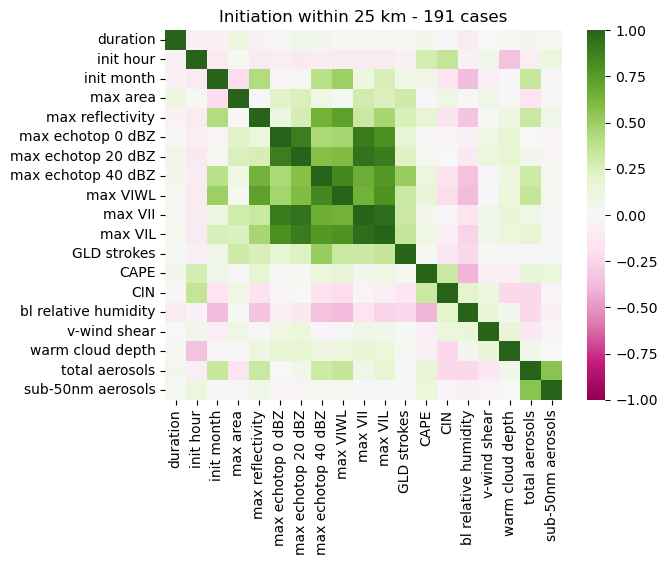

In [8]:
import seaborn as sns

sns.heatmap(systems.dropna().corr(), vmin=-1, vmax=1, cmap='PiYG').set_title("Initiation within 25 km - " + str(systems.dropna().shape[0]) + " cases")
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_map_init25.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)


In [9]:
systems.columns

Index(['date_init', 'duration', 'sys duration', 'init hour', 'time of day',
       'init month', 'season', 'max area', 'area', 'lifespan',
       'max reflectivity', 'reflectivity', 'max echotop 0 dBZ',
       'max echotop 20 dBZ', 'max echotop 40 dBZ', 'max VIWL', 'max VII',
       'max VIL', 'GLD strokes', 'electrical activity', 'CAPE', 'CIN',
       'bl relative humidity', 'v-wind shear', 'warm cloud depth',
       'total aerosols', 'sub-50nm aerosols'],
      dtype='object')

In [10]:
systems.to_csv('/home/camilacl/git/amazon-storms-aerosols/data/general/systems_filtered_25km.csv')

### Outros gráficos

<AxesSubplot:xlabel='total aerosols', ylabel='max reflectivity'>

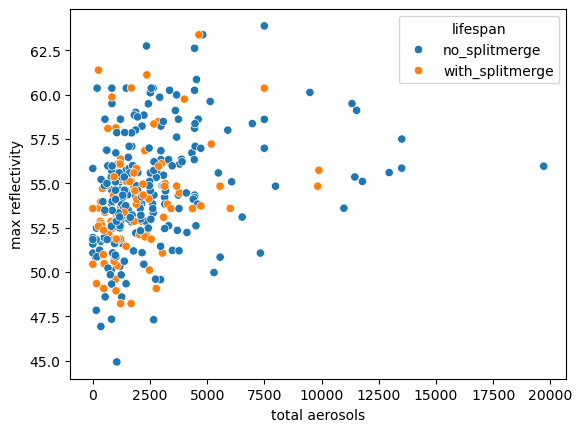

In [47]:
sns.scatterplot(data=systems, x="total aerosols", y="max reflectivity", hue="lifespan")

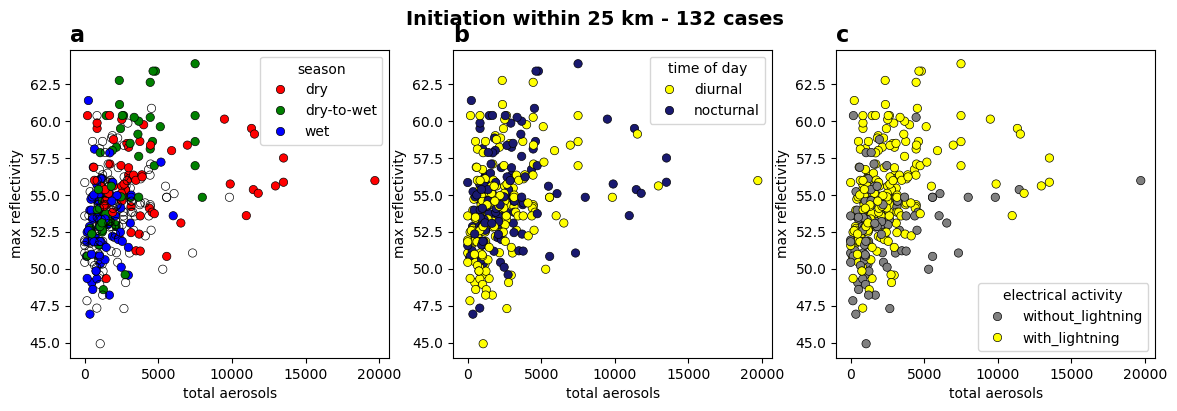

In [57]:
fig, axs = plt.subplots(figsize=(14,4), ncols=3)
season_order = ['dry', 'dry-to-wet', 'wet']

sns.scatterplot(data=systems, x="total aerosols", y="max reflectivity", hue="season", palette=['red','green', 'blue'], hue_order=season_order, edgecolor="black", ax=axs[0])
sns.scatterplot(data=systems, x="total aerosols", y="max reflectivity", hue="time of day", palette=['yellow','midnightblue'], edgecolor="black", ax=axs[1])
sns.scatterplot(data=systems, x="total aerosols", y="max reflectivity", hue="electrical activity", palette=["gray", "yellow"], edgecolor="black", ax=axs[2])
fig.suptitle("Initiation within 25 km - " + str(systems.dropna().shape[0]) + " cases", size=14, fontweight="bold")
axs[0].set_title("a", loc="left", fontweight="bold", size=16)
axs[1].set_title("b", loc="left", fontweight="bold", size=16)
axs[2].set_title("c", loc="left", fontweight="bold", size=16)
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_test_init25.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)

## Systems 10 km

In [11]:
# File paths
gld_path = "/home/camilacl/git/amazon-storms-aerosols/data/lightning/GLD_mod/"
radar_path = "/data2/GOAMAZON/radar/sipam_manaus/cptec_cappi/"
init_path = "/home/camilacl/git/amazon-storms-aerosols/data/general/"

# Load family
db = pgis.Loader(
    "localhost", "goamazon_geo", "postgres", "postgres", "systems_filtered"
)
# Get systems
names = db.loadNames()
# print(len(names))
# Get dates
dates = db.loadDates()
print(len(dates))

19199


In [12]:
# -- CS name, duration
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
names = [q[0] for q in db.query(query)]
durations = [q[1] for q in db.query(query)]

# -- Single params
query = (
    "SELECT DISTINCT ON (name) date_init10, totaerosol10_1_cm3, totccn10_1_cm3,"
    " cape10_j_kg, cin10_j_kg, blrh10_pc, lvws10_m_s, ufaerosol10_1_cm3, wcd10_km FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
date_init = [q[0] for q in db.query(query)]
totaerosol = [q[1] for q in db.query(query)]
totccn = [q[2] for q in db.query(query)]
cape = [q[3] for q in db.query(query)]
cin = [q[4] for q in db.query(query)]
blrh = [q[5] for q in db.query(query)]
lvws = [q[6] for q in db.query(query)]
ufaerosol = [q[7] for q in db.query(query)]
wcd = [q[8] for q in db.query(query)]

# -- Max, sum params
query = (
    "SELECT MAX(count), MAX(max), MAX(echotop_0), MAX(echotop_20),"
    " MAX(echotop_40), MAX(maxvil_kgm2), MAX(maxvii_kgm2), MAX(maxviwl_kgm2) FROM systems_filtered"
    " GROUP BY name ORDER BY name ASC"
)
maxarea = [q[0] for q in db.query(query)]
maxz = [q[1] for q in db.query(query)]
maxecho0 = [q[2] for q in db.query(query)]
maxecho20 = [q[3] for q in db.query(query)]
maxecho40 = [q[4] for q in db.query(query)]
maxvil = [q[5] for q in db.query(query)]
maxvii = [q[6] for q in db.query(query)]
maxviwl = [q[7] for q in db.query(query)]

query = "SELECT SUM(gld) FROM systems_filtered GROUP BY name ORDER BY name ASC"
gld = [q[0] for q in db.query(query)]

# -- Classifications
query = (
    "SELECT DISTINCT ON (name) clf_area, clf_z, clf_life, clf_duration,"
    " clf_season, clf_timeofday, clf_lightning FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
clf_area = [q[0] for q in db.query(query)]
clf_z = [q[1] for q in db.query(query)]
clf_life = [q[2] for q in db.query(query)]
clf_duration = [q[3] for q in db.query(query)]
clf_season = [q[4] for q in db.query(query)]
clf_timeofday = [q[5] for q in db.query(query)]
clf_lightning = [q[6] for q in db.query(query)]

In [13]:
systems_10 = pd.DataFrame(
    {
        'name': names,
        'duration': [float(d) for d in durations],
        'date_init': date_init,
        'max_area': maxarea,
        'max_z': maxz,
        'max_echotop0': maxecho0,
        'max_echotop20': maxecho20,
        'max_echotop40': maxecho40,
        'gld': gld,
        'totaerosol': totaerosol,
        'ufaerosol': ufaerosol,
        'cape': cape,
        'cin': cin,
        'blrh': blrh,
        'lvws': lvws,
        'wcd': wcd,
        'max_vil': maxvil,
        'max_vii': maxvii,
        'max_viwl': maxvil,
        'clf_area': clf_area,
        'clf_z': clf_z,
        'clf_life': clf_life,
        'clf_duration': clf_duration,
        'clf_season': clf_season,
        'clf_timeofday': clf_timeofday,
        'clf_lightning': clf_lightning,
    }
).set_index('name').replace(r'^\s*$', np.nan, regex=True)
systems_10['hour_init'] = systems_10.date_init.dt.hour
systems_10['month_init'] = systems_10.date_init.dt.month

In [14]:
systems_10 = systems_10.reindex(
    columns=['duration', 'date_init', 'hour_init', 'month_init', 'max_area', 
             'max_z', 'max_echotop0', 'max_echotop20', 'max_echotop40', 'gld',
             'totaerosol', 'ufaerosol', 'cape', 'cin', 'blrh', 'lvws', 
             'wcd', 'max_vil', 'max_vii', 'max_viwl', 'clf_area', 'clf_z', 'clf_life', 
             'clf_duration', 'clf_season', 'clf_timeofday', 'clf_lightning']
    )
systems_10.columns = [
    'duration', 
    'date_init', 
    'init hour', 
    'init month', 
    'max area', 
    'max reflectivity', 
    'max echotop 0 dBZ', 
    'max echotop 20 dBZ', 
    'max echotop 40 dBZ', 
    'GLD strokes',
    'total aerosols', 
    'sub-50nm aerosols', 
    'CAPE', 
    'CIN', 
    'bl relative humidity', 
    'v-wind shear', 
    'warm cloud depth',
    'max VIL', 
    'max VII', 
    'max VIWL',
    'area', 
    'reflectivity', 
    'lifespan', 
    'sys duration', 
    'season', 
    'time of day',
    'electrical activity'
]
systems_10 = systems_10[
    [
        'date_init', 
        'duration', 
        'sys duration', 
        'init hour', 
        'time of day',
        'init month', 
        'season', 
        'max area', 
        'area', 
        'lifespan', 
        'max reflectivity', 
        'reflectivity', 
        'max echotop 0 dBZ', 
        'max echotop 20 dBZ', 
        'max echotop 40 dBZ', 
        'max VIWL',
        'max VII', 
        'max VIL', 
        'GLD strokes',
        'electrical activity',
        'CAPE', 
        'CIN', 
        'bl relative humidity', 
        'v-wind shear', 
        'warm cloud depth',
        'total aerosols', 
        'sub-50nm aerosols', 
    ]
]

In [15]:
systems_10.dropna().describe()

,duration,init hour,init month,max area,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,max VIWL,max VII,max VIL,GLD strokes,CAPE,CIN,bl relative humidity,v-wind shear,warm cloud depth,total aerosols,sub-50nm aerosols
count,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000,101.000000
mean,79.366337,10.475248,7.366337,590.603960,55.172179,13.920792,12.811881,7.960396,0.322213,0.217340,0.322213,212.732673,2572.310664,-28.738925,79.739103,-1.513421,4.245421,2890.667051,680.216464
std,70.196827,7.768647,3.835943,538.866979,3.186729,1.701077,2.427809,2.760148,0.063481,0.076366,0.063481,675.556569,1592.159712,40.587751,10.083415,3.451793,0.443968,2915.562682,657.355163
min,0.000000,0.000000,1.000000,106.000000,48.210000,8.000000,5.000000,4.000000,0.161177,0.000000,0.161177,0.000000,-30.380970,-185.032380,51.800180,-9.552803,2.458601,168.498080,29.084630
25%,24.000000,5.000000,3.000000,246.000000,52.860000,14.000000,11.000000,6.000000,0.275174,0.174283,0.275174,1.000000,1185.476000,-46.866253,74.367645,-3.817045,4.111190,805.727900,213.738920
50%,60.000000,7.000000,9.000000,398.000000,54.830000,15.000000,14.000000,7.000000,0.336416,0.241560,0.336416,15.000000,2598.277600,-9.692022,79.167400,-1.636542,4.350689,1999.019200,472.687470
75%,120.000000,19.000000,11.000000,734.000000,56.980000,15.000000,15.000000,9.000000,0.366402,0.265663,0.366402,107.000000,3937.630000,0.000000,85.814620,0.051584,4.504025,3663.837400,990.935550
max,300.000000,23.000000,12.000000,3674.000000,65.380000,15.000000,15.000000,15.000000,0.440078,0.342747,0.440078,4997.000000,6351.676000,0.000000,99.623870,9.961557,5.211758,13501.296000,3141.172600


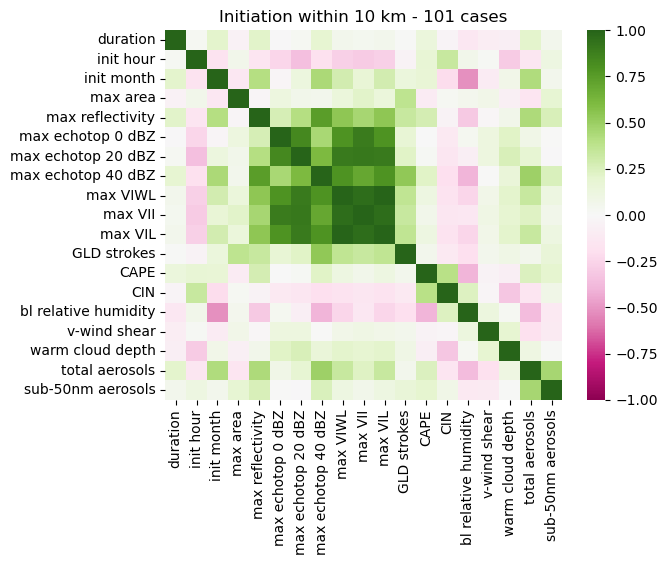

In [16]:
import seaborn as sns

sns.heatmap(systems_10.dropna().corr(), vmin=-1, vmax=1, cmap='PiYG').set_title("Initiation within 10 km - " + str(systems_10.dropna().shape[0]) + " cases")
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_map_init10.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)

In [17]:
systems_10.to_csv('/home/camilacl/git/amazon-storms-aerosols/data/general/systems_filtered_10km.csv')

In [18]:
systems_10.corr()

,duration,init hour,init month,max area,max reflectivity,max echotop 0 dBZ,max echotop 20 dBZ,max echotop 40 dBZ,max VIL,max VII,max VIWL,GLD strokes,CAPE,CIN,bl relative humidity,v-wind shear,warm cloud depth,total aerosols,ultrafine aerosols,total CCNs
duration,1.000000,0.043521,0.189757,0.031618,-0.001229,0.034618,0.037905,-0.001227,0.028023,0.032174,0.028023,0.011147,0.180759,0.020142,-0.139538,-0.062324,-0.033376,0.189997,0.025915,0.199622
init hour,0.043521,1.000000,-0.097121,0.054963,-0.034237,-0.045211,-0.158470,-0.056443,-0.086283,-0.092568,-0.086283,-0.015654,0.256774,0.349253,-0.027750,-0.036598,-0.387284,-0.147240,-0.103468,0.059749
init month,0.189757,-0.097121,1.000000,-0.099471,0.420605,0.089759,0.203556,0.488520,0.333905,0.238667,0.333905,0.186460,0.136620,-0.195068,-0.498741,-0.029991,-0.030980,0.455950,0.011326,0.524938
max area,0.031618,0.054963,-0.099471,1.000000,0.030742,0.182139,0.171781,0.075273,0.137227,0.183717,0.137227,0.240226,-0.071800,0.011395,0.095121,0.002808,-0.040812,-0.136066,0.036805,-0.070044
max reflectivity,-0.001229,-0.034237,0.420605,0.030742,1.000000,0.145182,0.232091,0.526400,0.346723,0.270922,0.346723,0.247524,0.233630,-0.045751,-0.358656,-0.017186,-0.043015,0.410447,0.186841,0.323056
max echotop 0 dBZ,0.034618,-0.045211,0.089759,0.182139,0.145182,1.000000,0.876147,0.470622,0.838780,0.903919,0.838780,0.168859,0.050757,-0.170247,-0.115965,0.161934,0.039686,0.106918,-0.151235,0.007649
max echotop 20 dBZ,0.037905,-0.158470,0.203556,0.171781,0.232091,0.876147,1.000000,0.610143,0.915578,0.925188,0.915578,0.222754,0.036233,-0.202608,-0.167884,0.146193,0.062084,0.212092,-0.090945,0.061064
max echotop 40 dBZ,-0.001227,-0.056443,0.488520,0.075273,0.526400,0.470622,0.610143,1.000000,0.759200,0.658635,0.759200,0.416331,0.227438,-0.168734,-0.416022,0.017750,-0.013324,0.475692,0.105668,0.432363
max VIL,0.028023,-0.086283,0.333905,0.137227,0.346723,0.838780,0.915578,0.759200,1.000000,0.950765,1.000000,0.299142,0.117349,-0.187679,-0.281796,0.115511,0.006292,0.311754,-0.057899,0.227093
max VII,0.032174,-0.092568,0.238667,0.183717,0.270922,0.903919,0.925188,0.658635,0.950765,1.000000,0.950765,0.281797,0.081543,-0.184728,-0.205410,0.133640,0.018018,0.234114,-0.096168,0.141910


### Other figs

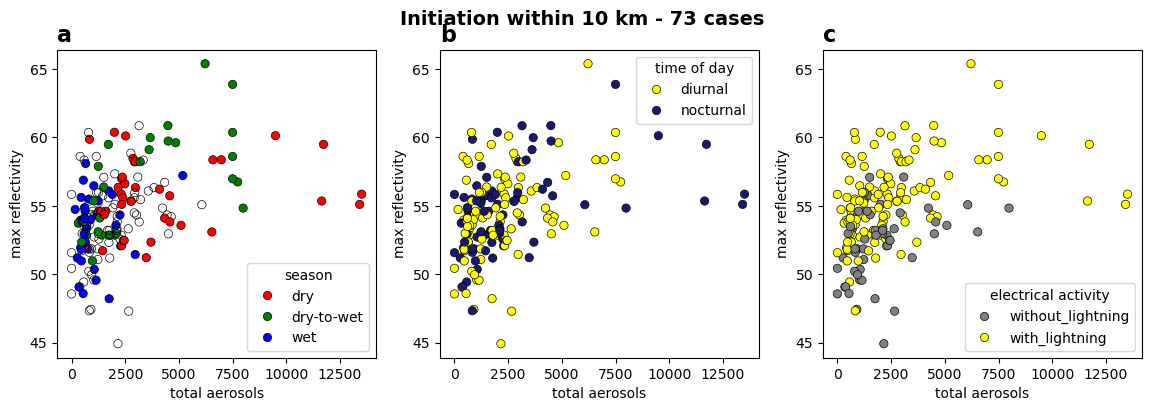

In [56]:
fig, axs = plt.subplots(figsize=(14,4), ncols=3)
season_order = ['dry', 'dry-to-wet', 'wet']

sns.scatterplot(data=systems_10, x="total aerosols", y="max reflectivity", hue="season", palette=['red','green', 'blue'], hue_order=season_order, edgecolor="black", ax=axs[0])
sns.scatterplot(data=systems_10, x="total aerosols", y="max reflectivity", hue="time of day", palette=['yellow','midnightblue'], edgecolor="black", ax=axs[1])
sns.scatterplot(data=systems_10, x="total aerosols", y="max reflectivity", hue="electrical activity", palette=["gray", "yellow"], edgecolor="black", ax=axs[2])
axs[0].set_title("a", loc="left", fontweight="bold", size=16)
axs[1].set_title("b", loc="left", fontweight="bold", size=16)
axs[2].set_title("c", loc="left", fontweight="bold", size=16)
fig.suptitle("Initiation within 10 km - " + str(systems_10.dropna().shape[0]) + " cases", size=14, fontweight="bold")
plt.savefig(
    "/home/camilacl/git/tathu/sipam-tracking/out/goamazon/figs/corr_test_init10.png",
    dpi=300,
    facecolor="none",
    bbox_inches="tight"
)

In [ ]:
# -- CS name, duration
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
names = [q[0] for q in db.query(query)]
durations = [q[1] for q in db.query(query)]
# -- CS Max area
query = "SELECT MAX(count) FROM systems_filtered GROUP BY name"
maxplots = [q[0] for q in db.query(query)]
# -- Cl max Z
query = "SELECT max FROM systems_filtered ORDER BY name, date_time ASC"
zmax = [q[0] for q in db.query(query)]
query = (
    "SELECT name, elapsed_time FROM (SELECT name, EXTRACT(epoch FROM"
    " (max(date_time) - min(date_time))/60) AS elapsed_time FROM"
    " systems_filtered GROUP BY name) AS duration"
)
gld = [q[0] for q in db.query(query)]

# -- Classifications
query = (
    "SELECT DISTINCT ON (name) clf_area, clf_z, clf_life, clf_duration,"
    " clf_season, clf_timeofday, clf_lightning FROM systems_filtered"
    " ORDER BY name, date_time ASC"
)
clf_area = [q[0] for q in db.query(query)]
clf_z = [q[1] for q in db.query(query)]
clf_life = [q[2] for q in db.query(query)]
clf_duration = [q[3] for q in db.query(query)]
clf_season = [q[4] for q in db.query(query)]
clf_timeofday = [q[5] for q in db.query(query)]
clf_lightning = [q[6] for q in db.query(query)]

In [ ]:
systems = pd.DataFrame(
    {
        'name': names,
        'clf_area': clf_area,
        'clf_z': clf_z,
        'clf_life': clf_life,
        'clf_duration': clf_duration,
        'clf_season': clf_season,
        'clf_timeofday': clf_timeofday,
        'clf_lightning': clf_lightning,
        'totaerosol': totaerosol,
    }
).dropna(subset=["totaerosol"]).drop(columns=['totaerosol']).set_index('name')

In [ ]:
systems

In [ ]:
type(systems.clf_season[2])

In [ ]:
systems.corr()